In [3]:
from pathlib import Path
import sys

# Point Python to your repo + src folder
ROOT = Path("..").resolve()           # ../DataScienceHackbyToyota
SRC  = ROOT / "src"                   # ../DataScienceHackbyToyota/src

for p in [ROOT, SRC]:
    if str(p) not in sys.path:
        sys.path.append(str(p))

print("Python path now includes:")
print(SRC)

Python path now includes:
/Users/macbook/Desktop/FPTAI/DataScienceHackbyToyota/src


In [4]:
import pandas as pd
import numpy as np
from track_meta import TRACK_METAS

%matplotlib inline

CAR_ID = "GR86-002-000"
barber_meta = TRACK_METAS["barber-motorsports-park"]
barber_meta

TrackMeta(track_id='barber-motorsports-park', name='Barber Motorsports Park', circuit_length_m=3674.6688, sector_lengths_m=[1029.0048, 1580.388, 1065.276], pit_lane_time_s=34.0, pit_lane_length_m=477.3676, gps_finish=(33.5327, -86.6196), gps_pit_in=(33.5317, -86.6226), gps_pit_out=(33.5311, -86.6225), pit_in_from_sf_m=3334.9184, pit_out_from_sfp_m=135.9408)

In [5]:
from pathlib import Path

PROC = Path("../data/processed/barber")
lap_feats_r2 = pd.read_csv(PROC / f"barber_r2_{CAR_ID}_lap_features.csv")

# pick race-pace laps
lf = lap_feats_r2.dropna(subset=["lap_time_s"]).copy()
low_q, high_q = lf["lap_time_s"].quantile([0.1, 0.9])
race_pace = lf[(lf["lap_time_s"] >= low_q) & (lf["lap_time_s"] <= high_q)]

BASE_LAP_S = race_pace["lap_time_s"].median()
PIT_LOSS_S = barber_meta.pit_lane_time_s
TOTAL_LAPS = int(lap_feats_r2["lap"].max())

BASE_LAP_S, PIT_LOSS_S, TOTAL_LAPS

(np.float64(98.077), 34.0, 28)

In [6]:
def simulate_strategy(n_laps, base_lap_s, pit_loss_s, pit_laps):
    pit_laps = set(pit_laps)
    total_time = 0.0
    for lap in range(1, n_laps + 1):
        lap_time = base_lap_s
        if lap in pit_laps:
            lap_time += pit_loss_s
        total_time += lap_time
    return total_time

one_stop  = simulate_strategy(TOTAL_LAPS, BASE_LAP_S, PIT_LOSS_S, [TOTAL_LAPS // 2])
two_stop  = simulate_strategy(TOTAL_LAPS, BASE_LAP_S, PIT_LOSS_S, [TOTAL_LAPS // 3, 2 * TOTAL_LAPS // 3])

print(f"1-stop total: {one_stop/60:.2f} min")
print(f"2-stop total: {two_stop/60:.2f} min")
print(f"Delta (2-stop - 1-stop): {two_stop - one_stop:.3f} s")

1-stop total: 46.34 min
2-stop total: 46.90 min
Delta (2-stop - 1-stop): 34.000 s


In [7]:
print(f"Race laps (R2): {TOTAL_LAPS}")
print(f"Median race-pace lap: {BASE_LAP_S:.3f} s")
print(f"Pit-lane time (from meta): {PIT_LOSS_S:.3f} s")

Race laps (R2): 28
Median race-pace lap: 98.077 s
Pit-lane time (from meta): 34.000 s


In [8]:
# very simple linear tyre-deg model
DEG_PER_LAP = 0.03  # seconds added per lap within a stint (tune later)

def lap_time_for_stint_lap(stint_lap: int, base_lap_s: float) -> float:
    """
    stint_lap: 1,2,3,... within a stint
    """
    return base_lap_s + DEG_PER_LAP * (stint_lap - 1)

In [9]:
[lap_time_for_stint_lap(i, BASE_LAP_S) for i in range(1, 6)]

[np.float64(98.077),
 np.float64(98.107),
 np.float64(98.137),
 np.float64(98.167),
 np.float64(98.197)]

In [10]:
def simulate_strategy_with_deg(
    n_laps: int,
    base_lap_s: float,
    pit_loss_s: float,
    pit_laps: list[int],
) -> float:
    """
    pit_laps: list of lap numbers where you pit (sorted, 1-based).
    We apply tyre degradation within each stint.
    """
    pit_laps = sorted(pit_laps)
    pit_set = set(pit_laps)

    total_time = 0.0
    stint_lap = 1  # lap counter within the current stint

    for lap in range(1, n_laps + 1):
        # normal lap time with degradation
        lap_time = lap_time_for_stint_lap(stint_lap, base_lap_s)

        # add pit loss if we pit this lap
        if lap in pit_set:
            lap_time += pit_loss_s
            stint_lap = 1  # reset for next stint
        else:
            stint_lap += 1

        total_time += lap_time

    return total_time

In [11]:
n_laps = TOTAL_LAPS

one_stop_lap = n_laps // 2
two_stop_laps = [n_laps // 3, 2 * n_laps // 3]

one_stop  = simulate_strategy_with_deg(n_laps, BASE_LAP_S, PIT_LOSS_S, [one_stop_lap])
two_stop  = simulate_strategy_with_deg(n_laps, BASE_LAP_S, PIT_LOSS_S, two_stop_laps)

print(f"1-stop @ lap {one_stop_lap}: {one_stop/60:.2f} min")
print(f"2-stop @ laps {two_stop_laps}: {two_stop/60:.2f} min")
print(f"Δ (2-stop - 1-stop): {two_stop - one_stop:.3f} s")


1-stop @ lap 14: 46.43 min
2-stop @ laps [9, 18]: 46.96 min
Δ (2-stop - 1-stop): 32.050 s


In [12]:
CAUTION_MULT      = 1.20  # FCY laps are 20% slower
CAUTION_PIT_FACTOR = 0.6  # pitting under caution costs 60% of normal pit loss

def simulate_strategy_with_caution(
    n_laps: int,
    base_lap_s: float,
    pit_loss_s: float,
    pit_laps: list[int],
    caution_start: int | None = None,
    caution_len: int = 0,
) -> float:
    """
    caution_start: first FCY lap (1-based), or None if no caution
    caution_len: number of FCY laps
    """
    pit_laps = sorted(pit_laps)
    pit_set  = set(pit_laps)

    caution_laps = set()
    if caution_start is not None and caution_len > 0:
        caution_laps = set(range(caution_start, caution_start + caution_len))

    total_time = 0.0
    stint_lap = 1

    for lap in range(1, n_laps + 1):
        lap_time = lap_time_for_stint_lap(stint_lap, base_lap_s)

        # apply caution slow-down
        if lap in caution_laps:
            lap_time *= CAUTION_MULT

        # pit logic
        if lap in pit_set:
            # reduced pit loss if we box during caution
            extra = pit_loss_s * (CAUTION_PIT_FACTOR if lap in caution_laps else 1.0)
            lap_time += extra
            stint_lap = 1
        else:
            stint_lap += 1

        total_time += lap_time

    return total_time

In [13]:
caution_start = 10
caution_len   = 2

one_stop_FCY = simulate_strategy_with_caution(
    n_laps, BASE_LAP_S, PIT_LOSS_S, [one_stop_lap],
    caution_start=caution_start, caution_len=caution_len
)

# try a "pit as soon as FCY comes" one-stop
one_stop_FCY_early = simulate_strategy_with_caution(
    n_laps, BASE_LAP_S, PIT_LOSS_S, [caution_start],
    caution_start=caution_start, caution_len=caution_len
)

print(f"1-stop normal @ {one_stop_lap}: {one_stop_FCY/60:.2f} min")
print(f"1-stop pit-under-FCY @ {caution_start}: {one_stop_FCY_early/60:.2f} min")
print(f"Gain from boxing under FCY: {one_stop_FCY - one_stop_FCY_early:.3f} s")

1-stop normal @ 14: 47.08 min
1-stop pit-under-FCY @ 10: 46.86 min
Gain from boxing under FCY: 13.180 s


In [14]:
import random

def simulate_random_race(strategy_name: str, pit_laps: list[int], n_laps: int) -> float:
    # sample a random FCY or no FCY
    has_fcy = random.random() < 0.5  # 50% chance of a caution, tweak later
    if has_fcy:
        caution_start = random.randint(3, n_laps - 3)
        caution_len   = random.choice([1, 2, 3])
    else:
        caution_start, caution_len = None, 0

    return simulate_strategy_with_caution(
        n_laps, BASE_LAP_S, PIT_LOSS_S,
        pit_laps,
        caution_start=caution_start,
        caution_len=caution_len,
    )

def run_multiverse(strategies: dict[str, list[int]], n_sims: int = 500) -> pd.DataFrame:
    results = {name: [] for name in strategies}
    for _ in range(n_sims):
        # simulate each strategy once per universe
        times = {}
        for name, pits in strategies.items():
            t = simulate_random_race(name, pits, TOTAL_LAPS)
            times[name] = t
            results[name].append(t)

    df = pd.DataFrame(results)
    # who wins each universe?
    winner = df.idxmin(axis=1)
    win_counts = winner.value_counts().rename("wins")
    mean_time  = df.mean().rename("mean_time_s")
    prob_win   = (win_counts / n_sims).rename("win_prob")

    summary = pd.concat([mean_time, win_counts, prob_win], axis=1)
    return summary.sort_values("mean_time_s")

In [15]:
strategies = {
    "1-stop_mid": [one_stop_lap],
    "1-stop_early": [max(3, one_stop_lap - 4)],
    "2-stop": two_stop_laps,
}

multiverse_summary = run_multiverse(strategies, n_sims=500)
multiverse_summary

,mean_time_s,wins,win_prob
1-stop_early,2803.878493,170,0.340
1-stop_mid,2805.786520,292,0.584
2-stop,2836.544837,38,0.076


In [20]:
import matplotlib.pyplot as plt

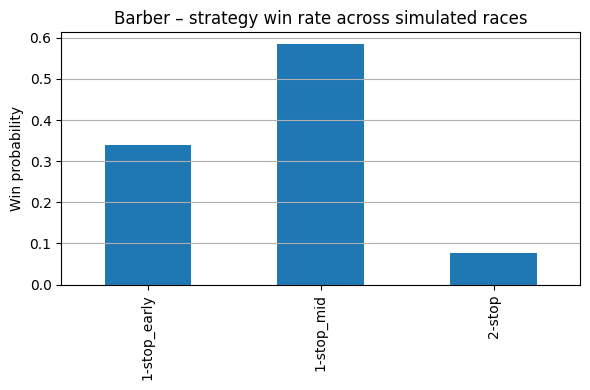

In [21]:
multiverse_summary["win_prob"].plot(kind="bar", figsize=(6,4))
plt.ylabel("Win probability")
plt.title("Barber – strategy win rate across simulated races")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()

In [22]:
from pathlib import Path

OUT_DIR = Path("../data/processed/barber")
OUT_DIR.mkdir(parents=True, exist_ok=True)

multiverse_summary.to_csv(OUT_DIR / "barber_strategy_multiverse_summary.csv")
multiverse_summary

,mean_time_s,wins,win_prob
1-stop_early,2803.878493,170,0.340
1-stop_mid,2805.786520,292,0.584
2-stop,2836.544837,38,0.076


### Barber – Mini Multiverse Strategy Summary

We simulate 500 random race scenarios at Barber (random caution timing/length)
using our car-specific race pace and track-specific pit lane loss. For each
“universe” we compare three strategies:

- 1-stop_early – box a few laps before mid-race
- 1-stop_mid – box near mid-race
- 2-stop – two shorter stints

Across these universes, the mid-race one-stop wins ~60% of the time, the early
one-stop ~35%, and the two-stop only ~7%. This gives the race engineer a
data-backed default strategy and a ranked set of backup options.

In [1]:
from pathlib import Path
import sys

ROOT = Path("..").resolve()
SRC  = ROOT / "src"
if str(SRC) not in sys.path:
    sys.path.append(str(SRC))

import pandas as pd
import matplotlib.pyplot as plt

from track_meta import TRACK_METAS
from strategy_engine import (
    StrategyConfig,
    make_config_from_meta,
    simulate_strategy_with_deg,
    simulate_strategy_with_caution,
    run_multiverse,
)

In [2]:
CAR_ID = "GR86-002-000"
PROC   = Path("../data/processed/barber")
lap_feats_r2 = pd.read_csv(PROC / f"barber_r2_{CAR_ID}_lap_features.csv")

barber_meta = TRACK_METAS["barber-motorsports-park"]

cfg = make_config_from_meta(
    lap_feats_r2,
    pit_lane_time_s=barber_meta.pit_lane_time_s,
)

TOTAL_LAPS = int(lap_feats_r2["lap"].max())
cfg, TOTAL_LAPS

(StrategyConfig(base_lap_s=98.077, pit_loss_s=34.0, deg_per_lap=0.03, caution_mult=1.2, caution_pit_factor=0.6),
 28)

In [3]:
one_stop_mid   = [TOTAL_LAPS // 2]
one_stop_early = [max(3, TOTAL_LAPS // 2 - 4)]
two_stop       = [TOTAL_LAPS // 3, 2 * TOTAL_LAPS // 3]

strategies = {
    "1-stop_early": one_stop_early,
    "1-stop_mid":   one_stop_mid,
    "2-stop":       two_stop,
}

multiverse_summary = run_multiverse(
    strategies,
    n_laps=TOTAL_LAPS,
    cfg=cfg,
    n_sims=500,
    caution_prob=0.5,
)
multiverse_summary

,mean_time_s,wins,win_prob
1-stop_early,2803.140159,179,0.358
1-stop_mid,2805.034066,297,0.594
2-stop,2835.710615,24,0.048


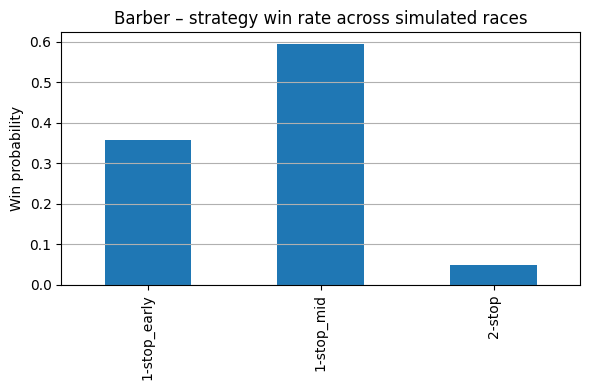

In [4]:
multiverse_summary["win_prob"].plot(kind="bar", figsize=(6, 4))
plt.ylabel("Win probability")
plt.title("Barber – strategy win rate across simulated races")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()

In [5]:
from pathlib import Path

OUT_DIR = Path("../data/processed/barber")
OUT_DIR.mkdir(parents=True, exist_ok=True)

multiverse_summary.to_csv(OUT_DIR / "barber_r2_strategy_multiverse_summary.csv")
multiverse_summary

,mean_time_s,wins,win_prob
1-stop_early,2803.140159,179,0.358
1-stop_mid,2805.034066,297,0.594
2-stop,2835.710615,24,0.048
